# Embeddings

In [1]:
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from natsort import natsorted
import os
from PIL import Image
from scipy.stats import pearsonr

In [5]:
# EMB_DIR = '../datasets/embeddings'
STIM_PATH = '../data/hpicked_ssnet_train/train'

device = torch.device("mps")

resnext = torchvision.models.resnext101_32x8d(torchvision.models.ResNeXt101_32X8D_Weights.IMAGENET1K_V2).to(device)
vit = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1).to(device)
resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(device)

In [8]:
torch.save(resnet,'../tutorials/offline_models/resnet/resnet')

In [4]:
list(resnet.named_children())

[('conv1',
  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)),
 ('bn1',
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 ('relu', ReLU(inplace=True)),
 ('maxpool',
  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)),
 ('layer1',
  Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), str

In [ ]:
cats = ['boats','cars', 'lights', 'airplanes', 'couches', 'chairs']
cats_dict = {
    'boats' : [],
    'cars' : [],
    'lights' : [],
    'airplanes' : [],
    'couches' : [],
    'chairs' : [],
    }

cat = 0
count = 0
for fp in natsorted(os.listdir(STIM_PATH)):
    fp = os.path.join(STIM_PATH, fp)
    for img_fp in os.listdir(fp):
        img_fp = os.path.join(fp, img_fp)
        if img_fp[-4:] == '.png':
            img = np.rollaxis(np.array(Image.open(img_fp), dtype=np.float32),2,0)
            cats_dict[cats[cat]].append(img)
    count += 1
    if count%3 == 0:
        cat += 1

In [ ]:
boats = torch.Tensor(np.array(cats_dict['boats'])).to(device)
cars = torch.Tensor(np.array(cats_dict['cars'])).to(device)
lights = torch.Tensor(np.array(cats_dict['lights'])).to(device)
airplanes = torch.Tensor(np.array(cats_dict['airplanes'])).to(device)
couches = torch.Tensor(np.array(cats_dict['couches'])).to(device)
chairs = torch.Tensor(np.array(cats_dict['chairs'])).to(device)

In [63]:
def img_encoder(model):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    
    model.encoder.layers.encoder_layer_11.register_forward_hook(get_activation('layer'))

    with torch.no_grad():
        boat_embs = model(boats)
        boat_embs = torch.flatten(torch.squeeze(activation['layer']), start_dim=1, end_dim=2)

        cars_embs = model(cars)
        cars_embs = torch.flatten(torch.squeeze(activation['layer']), start_dim=1, end_dim=2)

        lights_embs = model(lights)
        lights_embs = torch.flatten(torch.squeeze(activation['layer']), start_dim=1, end_dim=2)

        airplanes_embs = model(airplanes)
        airplanes_embs = torch.flatten(torch.squeeze(activation['layer']), start_dim=1, end_dim=2)

        couches_embs = model(couches)
        couches_embs = torch.flatten(torch.squeeze(activation['layer']), start_dim=1, end_dim=2)
        
        chairs_embs = model(chairs)
        chairs_embs = torch.flatten(torch.squeeze(activation['layer']), start_dim=1, end_dim=2)

    return torch.cat((boat_embs,cars_embs, lights_embs, airplanes_embs, couches_embs, chairs_embs))

embs = img_encoder(vit)

In [64]:
embs.shape

torch.Size([18, 151296])

# RDMs

In [65]:
def construct_RDM(activations):
	num_images = len(activations)
	print(num_images)
	RDM = np.zeros((num_images, num_images))

	for x in range(num_images):
		for y in range(num_images):
			if x<=y:
				correl = 1 - (pearsonr(activations[x].cpu().detach().numpy().flatten(), activations[y].cpu().detach().numpy().flatten()))[0]
				RDM[x][y] = correl
				RDM[y][x] = correl
	return RDM.astype(float)

rdm = construct_RDM(embs)

18


In [66]:
rdm.shape

(18, 18)

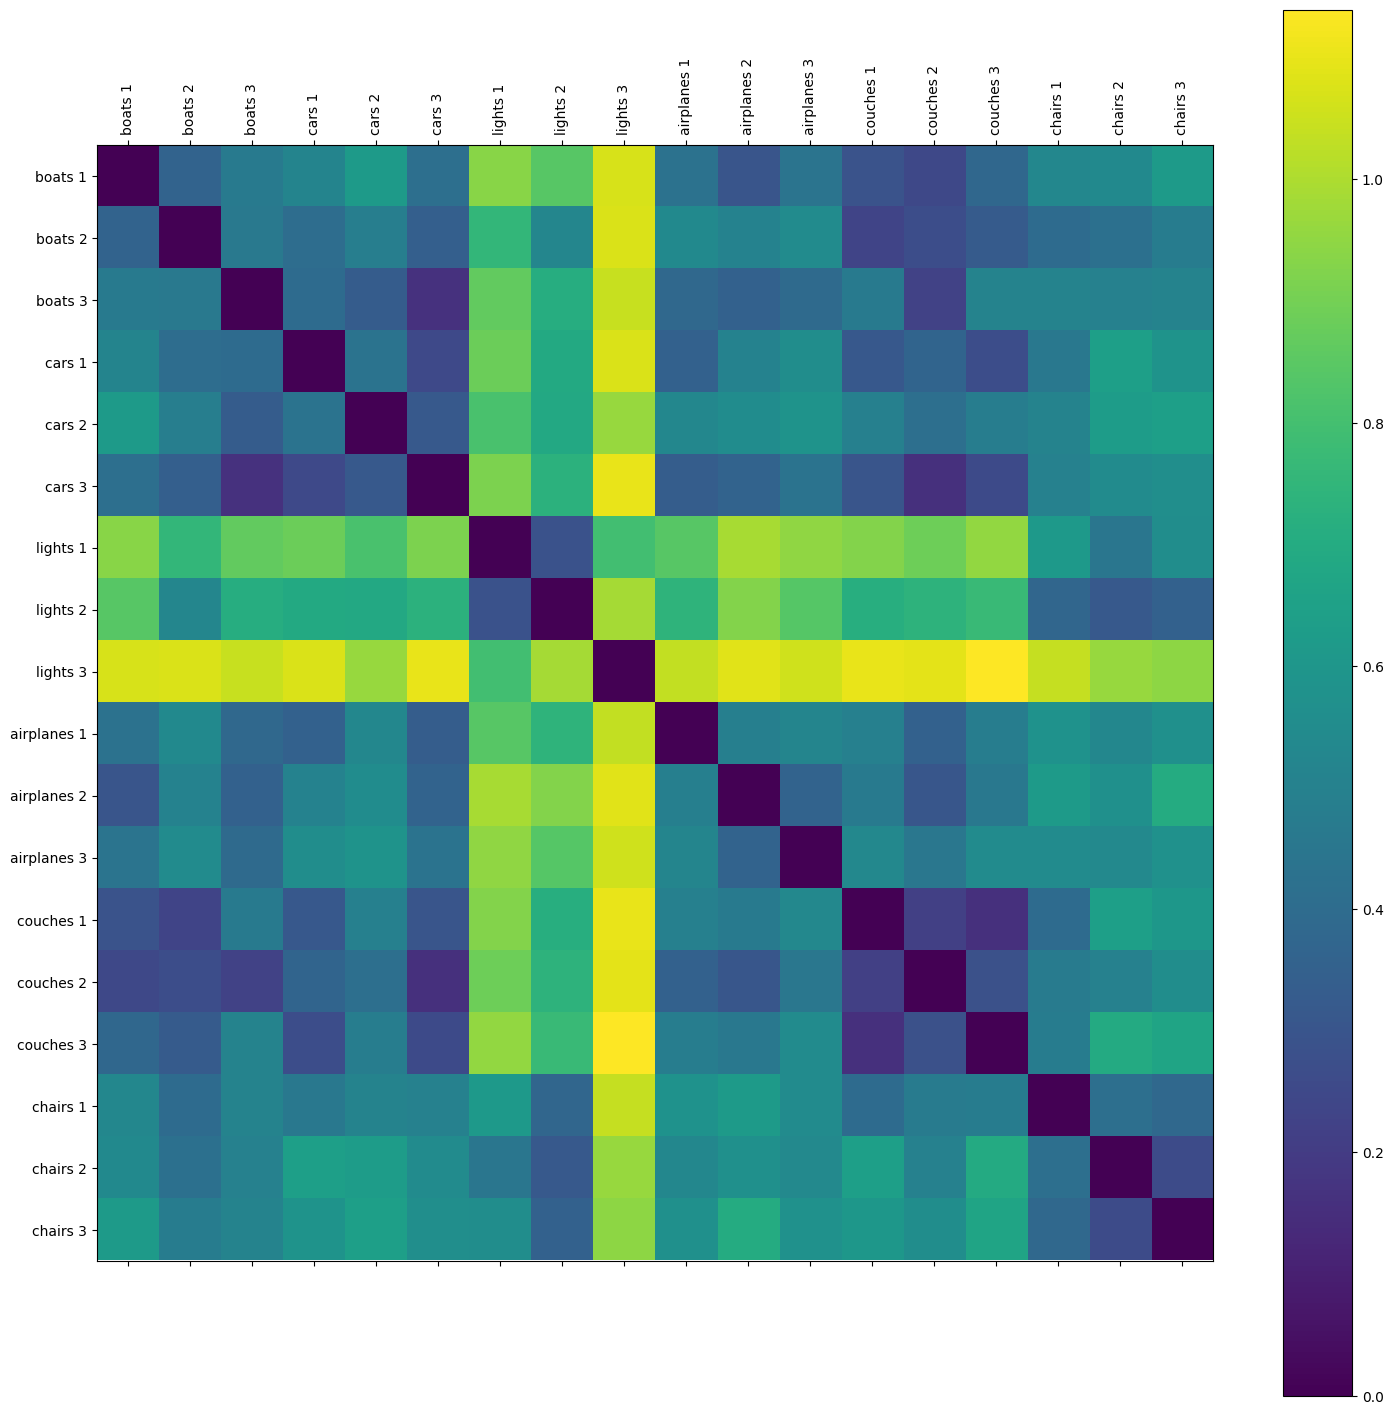

In [67]:
import matplotlib.pyplot as plt

labels = [cat + ' ' + str(x) for cat in cats_dict.keys() for x in [1,2,3] ]

fig, ax = plt.subplots(figsize=rdm.shape)
cax = ax.matshow(rdm, interpolation='nearest')
ax.grid(False)
plt.xticks(range(rdm.shape[0]), labels, rotation=90)
plt.yticks(range(rdm.shape[0]), labels)
fig.colorbar(cax)
plt.show()


# Classification

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
X, y = make_classification(n_features=4, random_state=0)
clf = make_pipeline(StandardScaler(), LinearSVC(dual="auto", random_state=0, tol=1e-5))
clf.fit(X, y)
print(clf.named_steps['linearsvc'].coef_)
print(clf.named_steps['linearsvc'].intercept_)


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(X, y)
reg.score(X, y)
reg.coef_
reg.intercept_
reg.predict(np.array([[3, 5]]))
